# Init

In [55]:
# dataset
FILENAME = "compounds_ms2structures"

# similarity calculation
MORGAN_RADIUS=9
FINGERPRINT_BITS=4096

# analogue selection
NUM_QUERIES = 1000
GROUP_SIZE=10
SIMILARITY_RANGE=(0.7, 0.9999)
NO_OVERLAP=False
RANDOM_SELECT = True   # Set to false to iterate through the dataset sequentially. Might be be better for high similarity selections.
SEED=42

In [56]:
import os
import sys
import ast
import pandas as pd
import numpy as np
import numba
from numba import prange
from tqdm.notebook import tqdm

from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFingerprintGenerator, SmilesMolSupplier

from fingerprint_computation import FingerprintGenerator, compute_fingerprints_from_smiles
from ms_chemical_space_explorer.similarity_maps import generate_mol, get_similarity_map_weights, FingerprintFunction

MAIN_FOLDER = os.path.abspath(
    os.path.join(os.getcwd(), "../ms_chemical_space_explorer")
)

print(f"Adding to path: {MAIN_FOLDER}")
sys.path.append(MAIN_FOLDER)

Adding to path: g:\Dokumente\Studium\MMI\Master-Arbeit\Code\ms_chemical_space_explorer


In [57]:
cse_file    = os.path.join("data", "explorer_group_size",            f"explorer_benchmark_size{GROUP_SIZE}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")
hi_sim_file = os.path.join("data", "group_similarity", "benchmarks",     f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")
lo_sim_file = os.path.join("data", "group_similarity", "benchmarks", f"{FILENAME}_dissimilarity_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

In [58]:
cse = pd.read_csv(cse_file, index_col=0)
cse.infer_objects()
cse.query_sims = cse.query_sims.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
cse.group_smiles = cse.group_smiles.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
cse

query_sim  query_mean_weights  group_sim       sgs  sgs_score  isf_score  \
0     0.497467            0.558742   0.405078  0.573357   0.873663   0.464615   
1     0.564973            0.430357   0.481543  0.375537   0.713101   0.533611   
2     0.441725            0.287829   0.286961  0.232405   0.918424   0.358662   
3     0.384393            0.311281   0.257695  0.253885   0.896323   0.332819   
4     0.038711            0.254861   0.158097  0.297997   0.825283   0.218916   
..         ...                 ...        ...       ...        ...        ...   
598   0.133716            0.268399   0.162466  0.236751   0.844461   0.208721   
599   0.200563            0.259171   0.235478  0.291538   0.851911   0.296077   
600   0.132660            0.245746   0.263362  0.241189   0.896551   0.336801   
601   0.176291            0.437209   0.184620  0.398653   0.886840   0.267700   
602   0.437958            0.254520   0.278448  0.291712   0.918484   0.314911   

     distance                                         query_sims  \
0    0.052562  [1.0, 1.0, 0.4490084985835694, 0.4490084985835...   
1    0.164563  [1.0, 1.0, 0.4317226890756303, 0.9396226415094...   
2    0.239114  [0.8890322580645161, 0.9922644163150492, 0.535...   
3    0.148705  [0.719585849870578, 0.8633540372670807, 0.7097...   
4    0.217851  [0.03816793893129771, 0.034420289855072464, 0....   
..        ...                                                ...   
598  0.209696  [0.19672131147540983, 0.21522055259331072, 0.1...   
599  0.169293  [0.24553571428571427, 0.2805243445692884, 0.28...   
600  0.283107  [0.1513975155279503, 0.16054313099041534, 0.15...   
601  0.177901  [0.22606924643584522, 0.22633744855967078, 0.2...   
602  0.157935  [0.7271662763466042, 0.6382153249272551, 0.570...   

                                            sgs_scores  \
0    [0.7919812396061213, 0.7674967281971505, 0.884...   
1    [0.5698866134510231, 0.5956265995868589, 0.800...   
2    [0.9189908263619687, 0.5085631010409168, 0.960...   
3    [0.7606499628040577, 0.8080465515209782, 0.869...   
4    [0.7590652289273833, 0.7942250613537059, 0.833...   
..                                                 ...   
598  [0.8675306956585733, 0.8511989481072275, 0.906...   
599  [0.7989459300358916, 0.8956261755364066, 0.858...   
600  [0.8369247014027069, 0.8337302848964019, 0.901...   
601  [0.8508501144568574, 0.8814432218873526, 0.760...   
602  [0.9282761697980747, 0.9247873761983957, 0.922...   

                                            isf_scores  \
0    [0.49783679371257056, 0.49783679371257056, 0.4...   
1    [0.5706207329787752, 0.5706207329787752, 0.569...   
2    [0.4530215089362769, 0.44444766580430367, 0.43...   
3    [0.4146367560411805, 0.40941776373259503, 0.39...   
4    [0.3901710495279119, 0.3842489379450639, 0.376...   
..                                                 ...   
598  [0.3247080609048947, 0.32096240842138857, 0.31...   
599  [0.4062001814618192, 0.39593904087955556, 0.39...   
600  [0.4415408302679574, 0.43784637498118195, 0.43...   
601  [0.4025160545100062, 0.4012036339043659, 0.398...   
602  [0.4631115135579087, 0.45315579164781095, 0.44...   

                                             distances  \
0    [0.050013158584950146, 0.049141692437410955, 0...   
1    [0.15275734984149203, 0.13455265127497307, 0.1...   
2    [0.21729594522723794, 0.2074173104551046, 0.23...   
3    [0.0632840427404735, 0.14618027498479103, 0.17...   
4    [0.21260299007505123, 0.20264563948719583, 0.2...   
..                                                 ...   
598  [0.21092174493130977, 0.20040720450176297, 0.1...   
599  [0.1822620960105168, 0.1718855616345315, 0.168...   
600  [0.28498434596792976, 0.2889179551818438, 0.29...   
601  [0.21586266002735688, 0.19749047266823405, 0.0...   
602  [0.15528226146492563, 0.15145699109016952, 0.1...   

                                          query_smiles  \
0    CCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1C([C...   
1    CCC

In [59]:
hi_sim = pd.read_csv(hi_sim_file, index_col=0)
hi_sim.infer_objects()
hi_sim.analogue_ids = hi_sim.analogue_ids.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
hi_sim

analogue_ids  query_sim  \
query_id                                                                 
35713     [23492, 6612, 788, 12150, 18256, 29122, 23200,...   0.757227   
6698      [9297, 4956, 9558, 22927, 18407, 4192, 36935, ...   0.728808   
23723     [4900, 21338, 4110, 34356, 19498, 21458, 6469,...   0.776946   
23219     [34068, 30328, 15327, 4203, 31300, 4192, 27915...   0.764761   
7161      [5401, 6018, 34482, 8816, 6420, 14039, 9393, 1...   0.752489   
...                                                     ...        ...   
9389      [12, 25711, 1846, 33912, 21350, 16668, 13371, ...   0.856211   
34088     [27120, 20763, 11214, 6487, 7447, 16501, 20032...   0.793224   
26225     [8055, 29135, 24062, 37303, 4502, 27413, 7567,...   0.754275   
5560      [7274, 13939, 25383, 22951, 11152, 14718, 3751...   0.804898   
26268     [10631, 32575, 8091, 5562, 16535, 4263, 7341, ...   0.778879   

          query_mean_weights  group_sim       sgs  sgs_score  
query_id                                                      
35713               0.745032   0.651649  0.718469   0.958369  
6698                0.699278   0.741461  0.711796   0.930022  
23723               0.779438   0.714194  0.768828   0.958988  
23219               0.690729   0.679330  0.671523   0.952904  
7161                0.736315   0.651582  0.704055   0.949291  
...                      ...        ...       ...        ...  
9389                0.724871   0.793353  0.725266   0.981181  
34088               0.760490   0.726373  0.781378   0.950357  
26225               0.721508   0.703045  0.700822   0.937447  
5560                0.802863   0.719795  0.793494   0.968366  
26268               0.714118   0.742973  0.742873   0.964622  

[1000 rows x 6 columns]

In [60]:
lo_sim = pd.read_csv(lo_sim_file, index_col=0)
lo_sim.infer_objects()
lo_sim.analogue_ids = lo_sim.analogue_ids.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
lo_sim.query_id_unsimilar = lo_sim.query_id_unsimilar.apply(lambda x: int(x) if isinstance(x, float) else x)
lo_sim

analogue_ids  query_sim  \
query_id                                                                 
35713     [23200, 15235, 23492, 16509, 788, 36440, 6612,...   0.757227   
6698      [4956, 18407, 36935, 14442, 34068, 12344, 9297...   0.728808   
23723     [6469, 4900, 21458, 21338, 4110, 2985, 4580, 3...   0.776946   
23219     [34068, 19889, 23098, 30328, 4192, 27915, 4203...   0.764761   
7161      [6420, 34482, 15048, 9393, 8816, 6018, 14039, ...   0.752489   
...                                                     ...        ...   
9389      [13371, 16668, 1846, 4964, 12, 26636, 25711, 3...   0.856211   
34088     [16501, 19951, 7447, 20032, 33526, 11214, 2076...   0.793224   
26225     [8055, 31010, 7549, 29135, 276, 7567, 27413, 3...   0.754275   
5560      [22951, 13939, 37510, 32822, 14718, 7274, 2215...   0.804898   
26268     [7341, 31715, 8091, 18091, 4263, 32575, 5562, ...   0.778879   

          group_sim       sgs  sgs_score  query_id_unsimilar  \
query_id                                                       
35713      0.651649  0.718469   0.958369                7296   
6698       0.741461  0.711796   0.930022                1639   
23723      0.714194  0.768828   0.958988               18024   
23219      0.679330  0.671523   0.952904               16049   
7161       0.651582  0.704055   0.949291               14628   
...             ...       ...        ...                 ...   
9389       0.793353  0.725266   0.981181               29804   
34088      0.726373  0.781378   0.950357               24155   
26225      0.703045  0.700822   0.937447               17181   
5560       0.719795  0.793494   0.968366               24970   
26268      0.742973  0.742873   0.964622               24344   

          query_sim_unsimilar  sgs_score_unsimilar  query_mean_weights  \
query_id                                                                 
35713                0.048941             0.495740            0.745032   
6698                 0.034004             0.529015            0.699278   
23723                0.019481             0.433941            0.779438   
23219                0.046053             0.593117            0.690729   
7161                 0.032426             0.504996            0.736315   
...                       ...                  ...                 ...   
9389                 0.012239             0.555282            0.724871   
34088                0.017810             0.413372            0.760490   
26225                0.028164             0.524335            0.721508   
5560                 0.043849             0.422505            0.802863   
26268                0.021773             0.451774            0.714118   

          mqw_unsimilar  sqs_unsimilar  
query_id                                
35713          0.242695       0.495740  
6698           0.240811       0.529015  
23723          0.202769       0.433941  
23219          0.264640       0.593117  
7161           0.224490       0.504996  
...                 ...            ...  
9389           0.291354       0.555282  
34088          0.312947       0.413372  
26225          0.225157       0.524335  
5560           0.233081       0.422505  
26268          0.203785       0.451774  

[1000 rows x 11 columns]

# Helper Functions

In [61]:
n=5
q = 0
a = 2

In [62]:
compounds_path = os.path.join( "data", "datasets", FILENAME + ".csv")
compounds = pd.read_csv(compounds_path)
mol_supplier = SmilesMolSupplier(compounds_path, delimiter=',', titleLine=True, smilesColumn=1, nameColumn=0)

In [63]:

from rdkit.Chem import MolFromSmiles

def get_analogue(df, q, a):
    """Get the rdkit Mol for analogue number 'a' from query with id 'q'"""
    if(df is cse):
        return MolFromSmiles(df.iloc[q].group_smiles[a])
    else:
        aid = hi_sim.iloc[q].analogue_ids[a]
        return mol_supplier[aid]

def get_query(df, q):
    """Get the rdkit Mol for query 'q'"""
    if(df is cse):
        return MolFromSmiles(df.iloc[q].query_smiles)
    elif(df is lo_sim):
        return mol_supplier[int(lo_sim.iloc[q].query_id_unsimilar)]
    else:
        return mol_supplier[int(hi_sim.iloc[q].name)]

def get_analogue_all(df, q):
    """Get the rdkit Mol for analogue number 'a' from query with id 'q'"""
    if(df is cse):
        return [MolFromSmiles(x) for x in df.iloc[q].group_smiles]
    else:
        return [mol_supplier[a] for a in hi_sim.iloc[q].analogue_ids]

get_analogue_all(lo_sim, q)

In [64]:
def get_analogue_smiles(df, q, a):
    """Get the SMILES for analogue number 'a' from query with id 'q'"""
    if(df is cse):
        return df.iloc[q].group_smiles[a]
    else:
        aid = hi_sim.iloc[q].analogue_ids[a]
        return compounds.smiles[aid]

def get_query_smiles(df, q):
    """Get the SMILES for query 'q'"""
    if(df is cse):
        return df.iloc[q].query_smiles
    elif(df is lo_sim):
        return compounds.smiles[lo_sim.iloc[q].query_id_unsimilar]
    else:
        return compounds.smiles[hi_sim.iloc[q].name]

def get_analogue_smiles_all(df, q):
    """Get the SMILES for analogue number 'a' from query with id 'q'"""
    if(df is cse):
        return df.iloc[q].group_smiles
    else:
        aids = hi_sim.iloc[q].analogue_ids
        return compounds.smiles[aids].values.tolist()

get_analogue_smiles_all(cse, q)
get_query_smiles(lo_sim, q)

'CCCCCCN1C=C(C=C1C2=CC=CC=C2)C(=O)C3=CC=CC4=CC=CC=C43'

In [65]:
from ms_chemical_space_explorer.similarity_maps import FingerprintFunction

fp_function = FingerprintFunction(fingerprint = "MORGAN")
fp_function.fp_type = "count"
fp_function.nbits = FINGERPRINT_BITS
fp_function.morgan_radius = MORGAN_RADIUS

In [66]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=MORGAN_RADIUS, fpSize=FINGERPRINT_BITS)

def get_sim(ref, probe):
    return DataStructs.TanimotoSimilarity(fpgen.GetCountFingerprint(ref), fpgen.GetCountFingerprint(probe))

def ruzicka_similarity(A, B):
    min_sum = np.sum(np.minimum(A, B))
    max_sum = np.sum(np.maximum(A, B))
    
    return min_sum / max_sum

In [67]:
sim_matrix_file = os.path.join("data", "group_similarity", f"{FILENAME}_ruzicka_similarities_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
sim_matrix = np.load(sim_matrix_file, mmap_mode ='r')

print([sim_matrix[lo_sim.iloc[q].query_id_unsimilar][aid] for aid in lo_sim.iloc[q].analogue_ids])
print([sim_matrix[hi_sim.iloc[q].name][aid] for aid in hi_sim.iloc[q].analogue_ids])

[0.048076924, 0.04693141, 0.050301813, 0.04914934, 0.0513834, 0.051124744, 0.049115915, 0.047058824, 0.05108055, 0.04518664]
[0.8888889, 0.80454546, 0.77578473, 0.76274943, 0.74834436, 0.726087, 0.7237687, 0.72131145, 0.71218485, 0.7086093]


In [68]:
from io import BytesIO
from PIL import Image

def str_to_image(byte_data: str) -> Image.Image:
    bio = BytesIO(byte_data)
    return Image.open(bio)

In [69]:
def draw_images(imgs: list[Image.Image], buffer: int = 5, max_ratio: float = 9.1) -> Image.Image:
    result = imgs[0]
    for i, img in enumerate(imgs[1:], start=1):
        width = result.width + buffer + img.width
        height = max(result.height, img.height)
        if (width / height) <= max_ratio:
            # print(f"Add Horizontal at {i}. Ratio: {width/height}")
            result = stack_images(result, img, vertical=False)
        else:
            # print(f"Add Vertical at {i}. Ratio: {width/height}")
            result = stack_images(result, draw_images(imgs[i:], buffer=buffer, max_ratio=max_ratio), vertical=True)
            break
    return result


def stack_images(img1: Image.Image, img2: Image.Image, vertical: bool = True, buffer: int = 5) -> Image.Image:
    img1_xoffset = 0
    img1_yoffset = 0
    img2_xoffset = 0
    img2_yoffset = 0

    # Calculate dimensions + offsets
    if vertical:
        if img1.width > img2.width:
            total_width = img1.width
            #img2_xoffset = (img1.width - img2.width) // 2
        else:
            total_width = img2.width
            #img1_xoffset = (img2.width - img1.width) // 2

        total_height = img1.height + buffer + img2.height
    else:
        if img1.height > img2.height:
            total_height = img1.height
            img2_yoffset = (img1.height - img2.height) // 2
        else:
            total_height = img2.height
            img1_yoffset = (img2.height - img1.height) // 2
        total_width = img1.width + buffer + img2.width

    # Create new image
    combined = Image.new("RGBA", (total_width, total_height))

    # Paste images
    combined.paste(img1, (img1_xoffset, img1_yoffset))
    if vertical:
        combined.paste(img2, (img2_xoffset, img1.height + buffer))
    else:
        combined.paste(img2, (img1.width + buffer, img2_yoffset))

    return combined

In [82]:
from rdkit.Chem import Draw
from ms_chemical_space_explorer.chemical_space_visualizer import (
    draw_sim_map,
    #draw_images,
    #stack_images,
    SimMapLegend
)
from ms_chemical_space_explorer.similarity_maps import get_similarity_map_weights, get_group_similarity_map_weights, get_similarity_map_byte_source

def generate_similarity_visualization(query_id, df, mol_img_size=400, overwrite_existing=False):
    if df is cse:
        dataset_name = "cse"
    elif df is hi_sim:
        dataset_name = "hi_sim"
    elif df is lo_sim:
        dataset_name = "lo_sim"
    else:
        dataset_name = "unknown"
    
    file = f"simmap_sample_{dataset_name}_{query_id}.png"
    file_path = os.path.join("imgs", "simmap_samples", file)
    
    if not overwrite_existing and os.path.exists(file_path):
        print(f"File {file_path} already exists. Skipping generation.")
        return Image.open(file_path)
    
    print(f"Computing Similarities...")
    query = get_query(df, query_id)
    amols = get_analogue_all(df, query_id)
    
    if df is cse:
        query_fp = fpgen.GetCountFingerprint(query)
        analogue_fps = [fpgen.GetCountFingerprint(mol) for mol in amols]
        similarities = [DataStructs.TanimotoSimilarity(query_fp, fp) for fp in analogue_fps]
    elif df is hi_sim:
        similarities = [sim_matrix[hi_sim.iloc[query_id].name][aid] for aid in hi_sim.iloc[query_id].analogue_ids]
    else:  # lo_sim
        similarities = [sim_matrix[lo_sim.iloc[query_id].query_id_unsimilar][aid] for aid in hi_sim.iloc[query_id].analogue_ids]

    print(f"Generating SimMaps...")
    size = [mol_img_size, mol_img_size]
    query_sim_maps = []
    group_sim_maps = {}

    for i, a in enumerate(amols):
        draw2d = Draw.MolDraw2DCairo(mol_img_size, mol_img_size)

        legend = SimMapLegend(f"query sim:\n{similarities[i]:.4}", size=mol_img_size/10)
        query_sim_maps.append(draw_sim_map(draw2d, query, a, fp_function=fp_function.get_function, legend=legend))
        
        if i < 2:
            continue
        
        weigths = get_group_similarity_map_weights(amols[:i], fp_function=fp_function)
        group_sim_maps[i] = []
        for j, w in enumerate(weigths):
            bytes = get_similarity_map_byte_source(amols[j], w, size=size)
            img = str_to_image(bytes)
            group_sim_maps[i].append(img)

    weigths = get_group_similarity_map_weights(amols, fp_function=fp_function)
    group_sim_maps[10] = []
    for j, w in enumerate(weigths):
        bytes = get_similarity_map_byte_source(amols[j], w, size=size)
        img = str_to_image(bytes)
        group_sim_maps[10].append(img)

    print(f"Composing final image...")
    group_sim_maps_all = []
    for i, imgs in group_sim_maps.items():
        group_sim_maps_all.append(draw_images(imgs, max_ratio=11))

    query_sim_maps_img =  draw_images(query_sim_maps, max_ratio=11)
    group_maps_img =  draw_images(group_sim_maps_all, max_ratio=3)
    final_img = stack_images(group_maps_img, query_sim_maps_img)

    query_img_ratio = 4
    query_img_size = query_img_ratio * mol_img_size + 5 * (query_img_ratio - 1)

    draw2d = Draw.MolDraw2DCairo(query_img_size, query_img_size)
    draw2d.DrawMolecule(query)
    draw2d.FinishDrawing()
    query_img = str_to_image(draw2d.GetDrawingText())

    x_offset = final_img.width - query_img.width
    final_img.paste(query_img, (x_offset, 0))#mol_img_size + 5))
    
    print(f"Saving image to {file_path}...")
    final_img.save(file_path, format='PNG', quality=95)
    return final_img

# Vis

## basic plotting

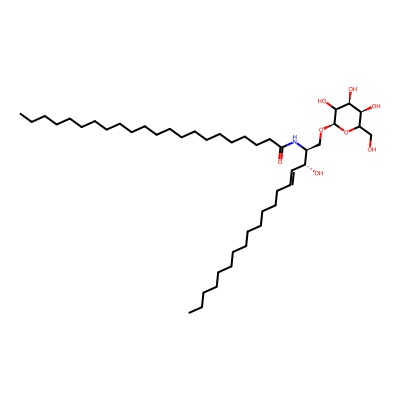

In [71]:
from rdkit.Chem import Draw
from ms_chemical_space_explorer.chemical_space_visualizer import (
    #draw_images,
    draw_mol,
)

draw2d = Draw.MolDraw2DCairo(400, 400)
draw_mol(draw2d, get_query(cse, q) )

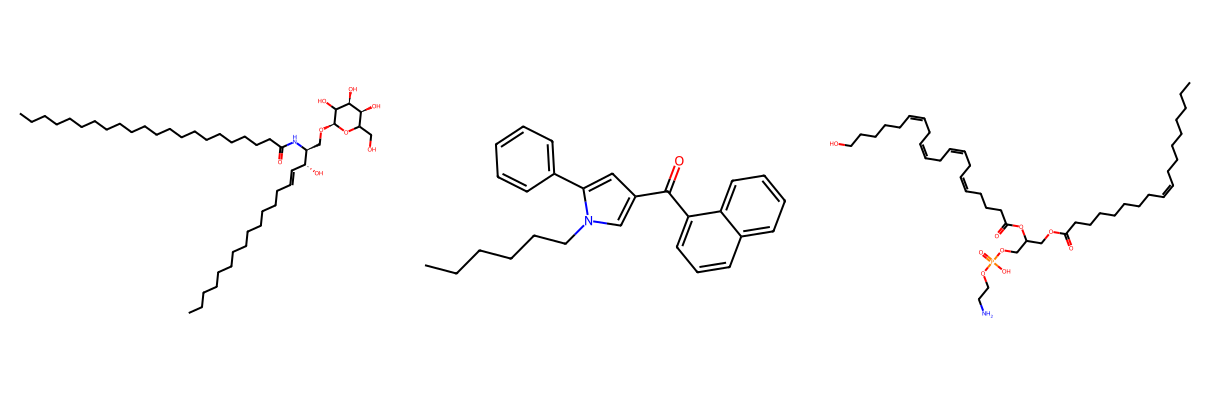

In [72]:
draw_images([draw_mol(Draw.MolDraw2DCairo(400, 400), get_query(df, q)) for df in [cse, lo_sim, hi_sim]],)

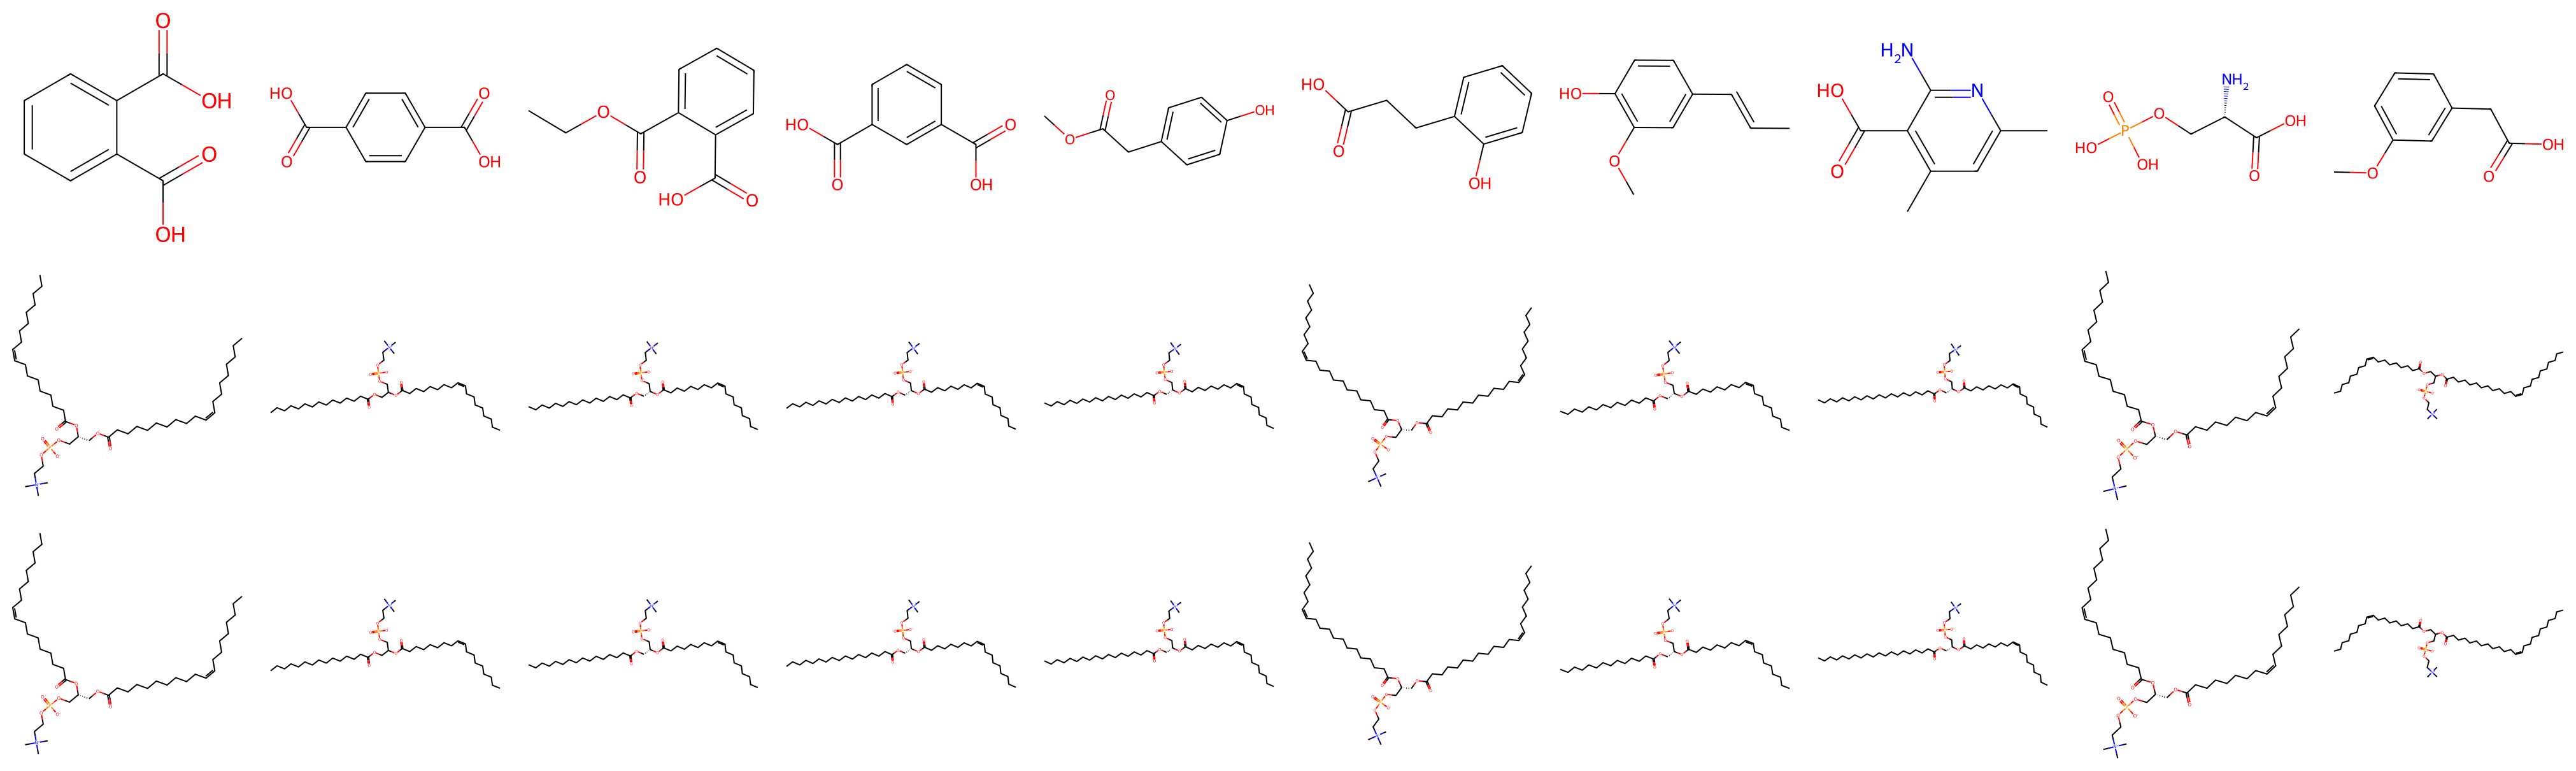

In [73]:
analogues_all = [get_analogue_all(df, 15) for df in [cse, lo_sim, hi_sim]]
draw_images([draw_images([draw_mol(Draw.MolDraw2DCairo(400, 400), a) for a in analogues], max_ratio=11) for analogues in analogues_all])

## sim maps

good example: cse: qid=140

Computing Similarities...
Generating SimMaps...
Composing final image...
Saving image to imgs\simmap_samples\simmap_sample_cse_140.png...


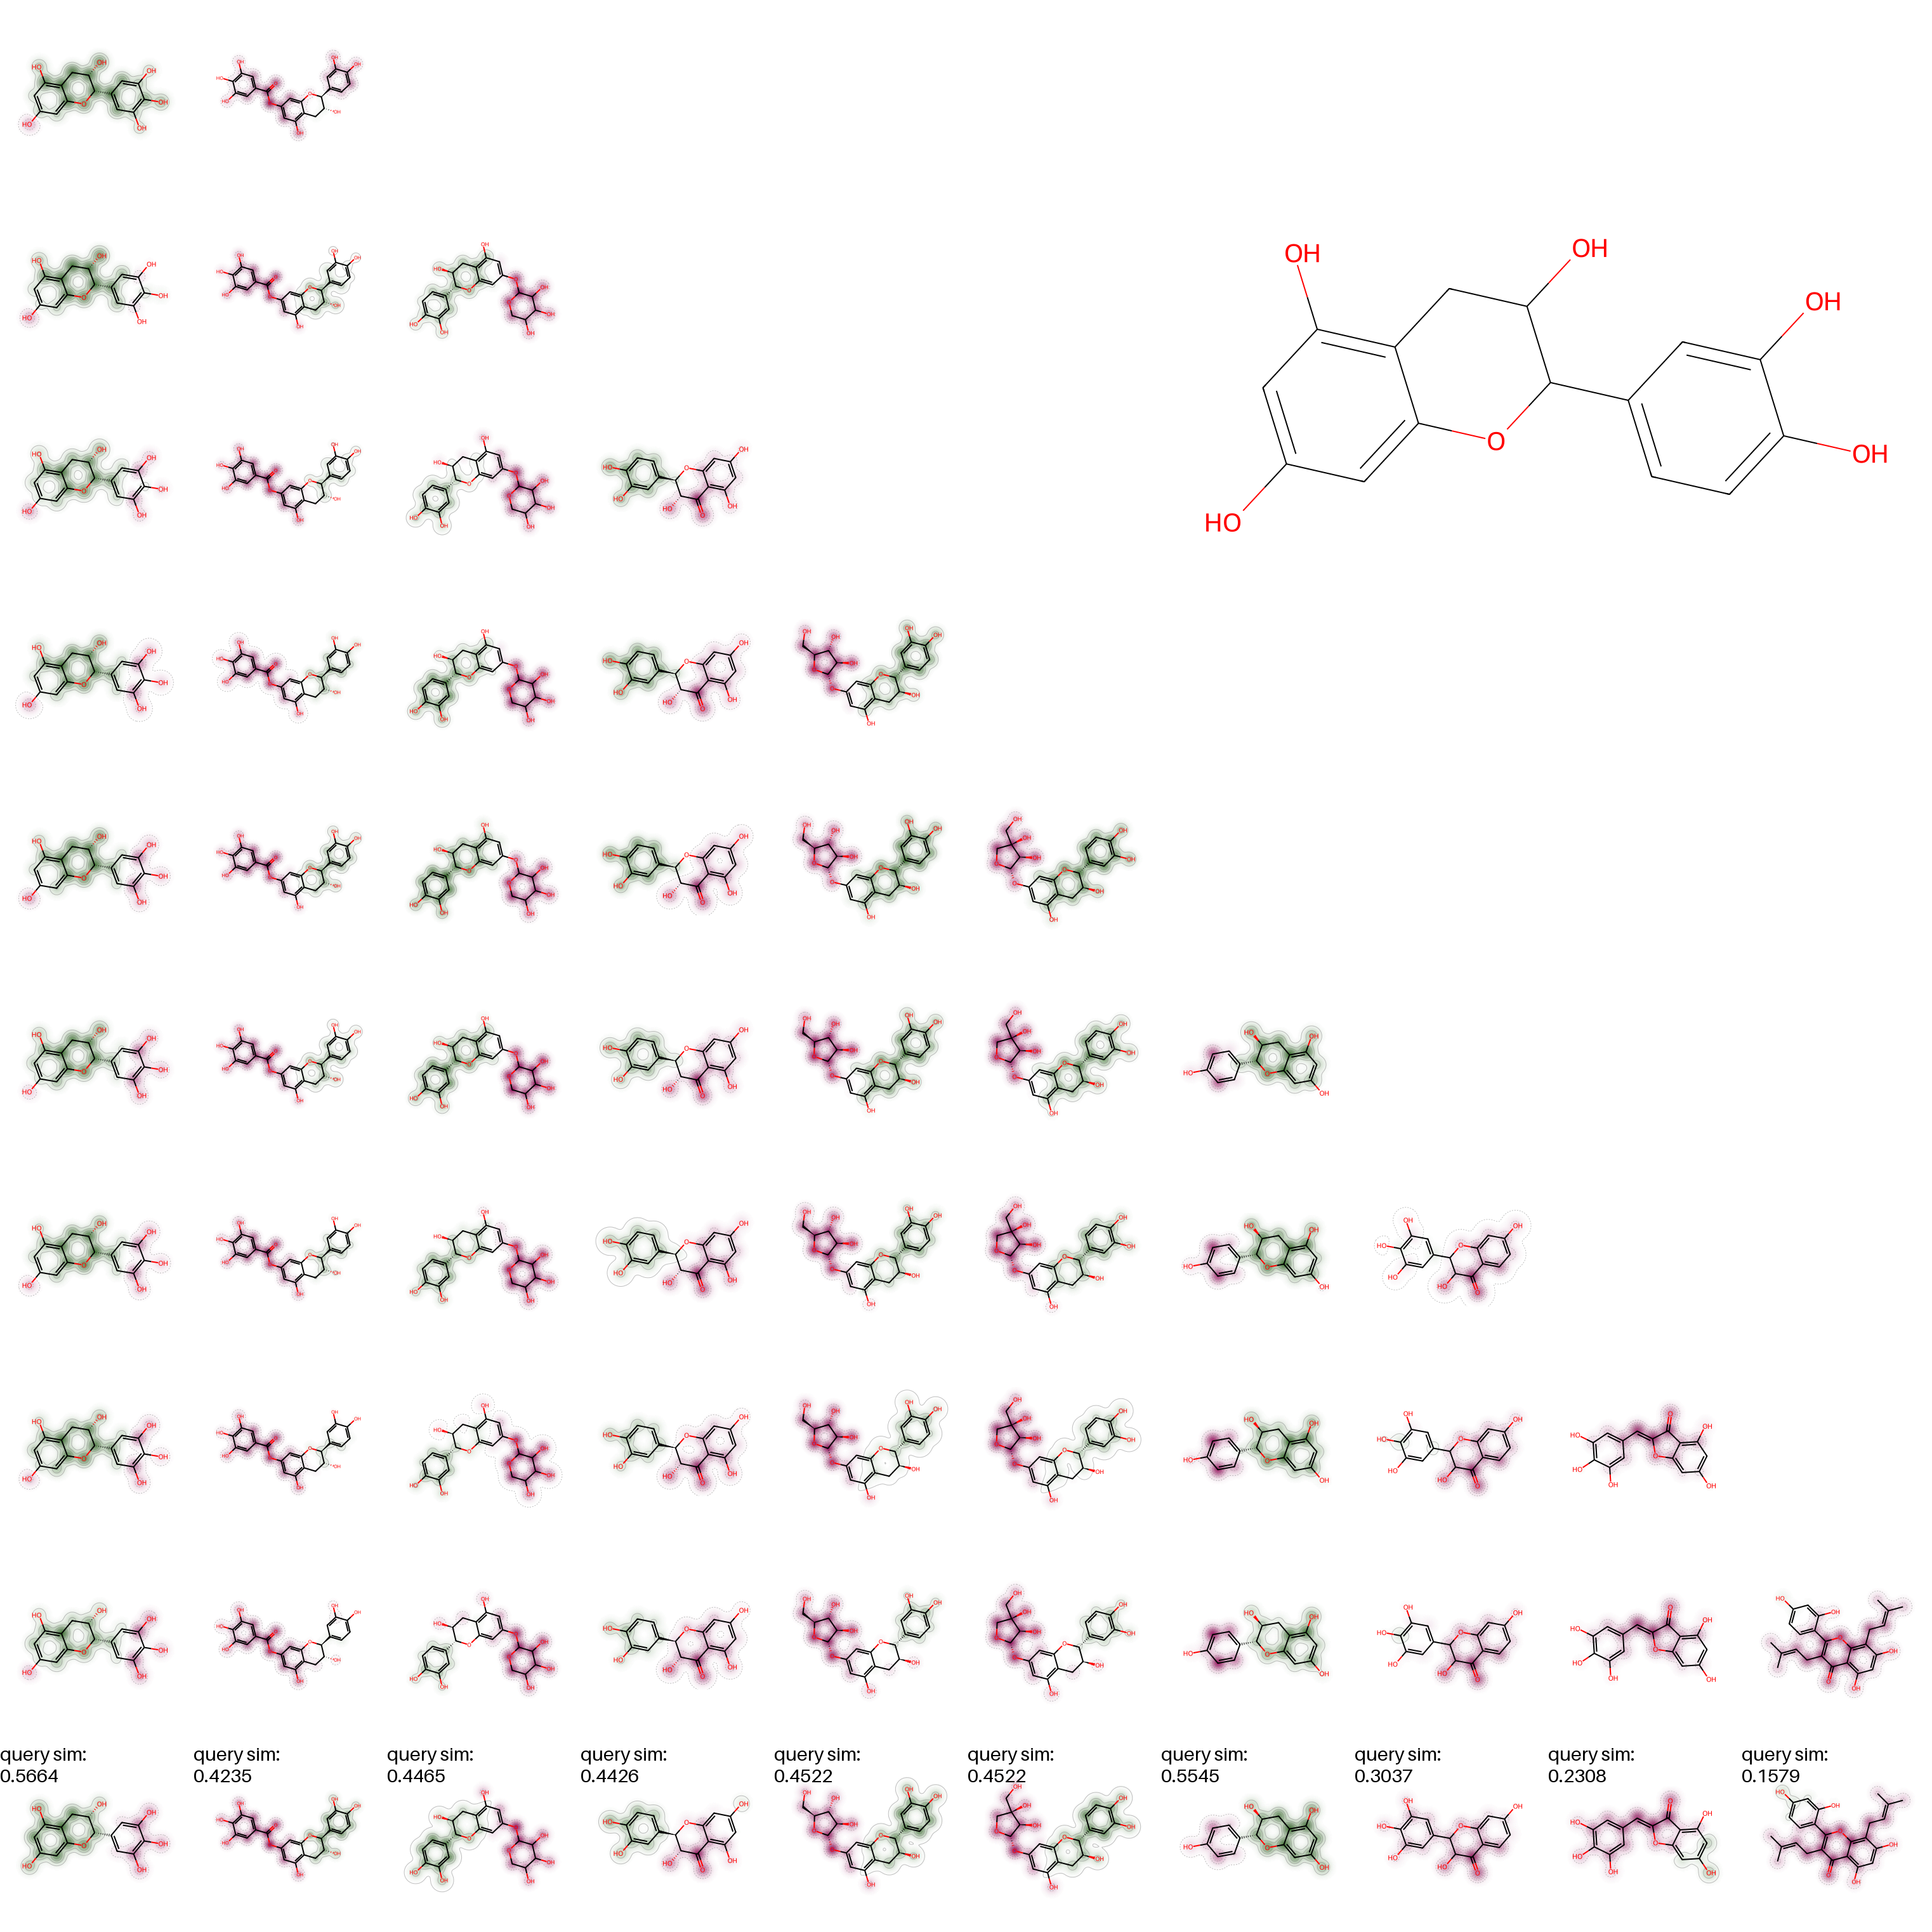

In [88]:
query_id = 140
df = cse
mol_img_size = 300

generate_similarity_visualization(query_id, df, mol_img_size=mol_img_size, overwrite_existing=True)